In [1]:
import os
import pandas as pd
import numpy as np
import math

from PIL import Image 
from IPython.display import display

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
fps=20
npoints=16384 # 1024*16
nchannel=16
# inputpath='/media/felicia/Data/ouster_data/-1024x10'
inputpath='/ouster_data/-1024x10'
framefile='-1024x10 (Frame %s).csv'

frame=1

In [4]:
dir_list=os.listdir(inputpath)
lidar_df=pd.read_csv(os.path.join(inputpath,framefile%"{:04d}".format(frame)),header=0)

In [5]:
xyz_df=lidar_df[["Point:0","Point:1","Point:2","Channel","Raw Timestamp"]]
# xyz_values=xyz_df.values
xyz_np=xyz_df.values.reshape((-1,16,5))

In [6]:
xyz_base=np.ma.masked_equal(xyz_np, 0).mean(axis=1)
timestamp=np.ma.masked_equal(xyz_base[:,-1], 0).mean(axis=0)

In [7]:
xy_sigma=[]
xy_nn=[]
for i in range(1024):
    positions=xyz_np[i,:,:2] # x,y
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(positions)
    dists, idxs = nbrs.kneighbors(positions)
    xy_sigma.append(dists[:,1])
    xy_nn.append(positions[idxs[:,1]])
xy_sigma=np.array(xy_sigma)
xy_nn=np.array(xy_nn)

In [8]:
sigmas=[]
for i in np.arange(0,1,0.1):
    sigmas.append(np.quantile(xy_sigma,i))

In [9]:
sigmas

[0.0,
 0.0004950433061395186,
 0.001160586778871903,
 0.0017514231818875972,
 0.0025548595528198824,
 0.003843781104707735,
 0.005873371097075409,
 0.009238961404635572,
 0.016681504124702293,
 0.05184437981674968]

In [10]:
sigma=np.mean(xy_sigma)
sigma

0.062280895297946656

In [11]:
sigma=np.mean(xy_sigma)

xy_positions=xyz_np[:,:,:2]
xy_proj=[]
proj_dict=defaultdict(list)
for i in range(1024):
    ox,oy=xy_positions[i,0]
    temp=[[ox,oy,i,0]]
    for j in range(1,16):
        x,y=xy_positions[i,j]
        dist=np.linalg.norm([ox-x,oy-y])
        if dist < sigma:
            temp.append([ox,oy,i,j])
            ox,oy,_,_=np.mean(temp,axis=0)
        else:
            xy_proj.append([ox,oy])
            
            for ele in temp:
                _,_,idxi,idxj=ele
                proj_dict[(ox,oy)].append([idxi,idxj])
            ox,oy=x,y
            temp=[[ox,oy,i,j]]      
xy_proj=np.array(xy_proj)
xy_radius=np.linalg.norm(xy_proj,axis=1)

In [12]:
xy_nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(xy_proj)
dists, idxs = xy_nbrs.kneighbors(xy_proj)
xy_delta=dists[:,1]

In [13]:
xy_delta

array([0.01458813, 0.00752096, 0.00752096, ..., 0.02432747, 0.02060643,
       0.02060643])

In [14]:
z_delta=[]
for x,y in xy_proj:
    idxs=np.array(proj_dict[(x,y)])
    z_positions=np.array([xyz_np[idxi,idxj,2] for idxi,idxj in idxs]).reshape(-1,1)
    if len(z_positions)>1:
        z_delta.append(sorted(pairwise_distances(z_positions)[0])[1])
    else:
        z_delta.append(0)
z_delta=np.array(z_delta)

In [15]:
# np.count_nonzero(xy_proj[:,0])
len(xy_proj)

4151

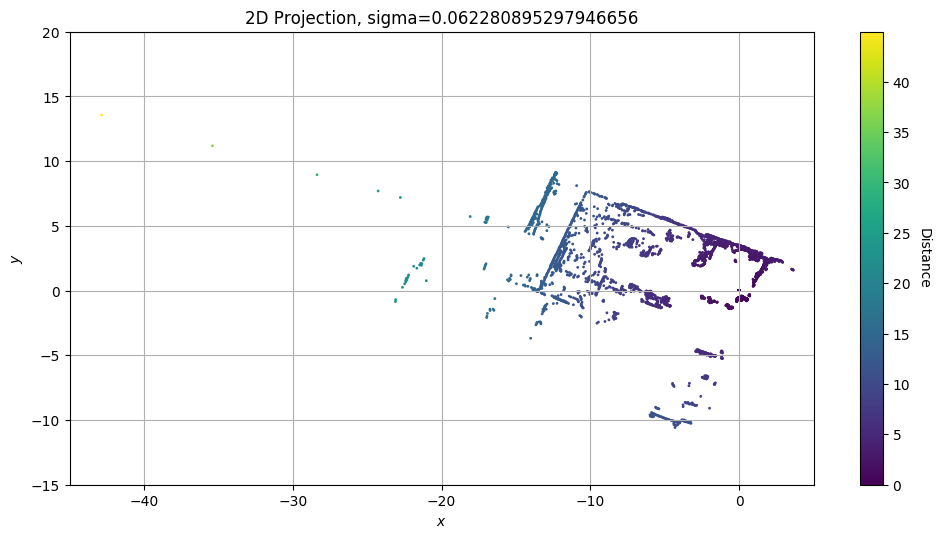

In [16]:
%matplotlib inline

fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(xy_proj[:,0], xy_proj[:,1],s=1,c=xy_radius, alpha=1,cmap='viridis')
plt.grid()
cbar=plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Distance', rotation=270)
plt.xlim(-45,  5)
plt.ylim(-15, 20)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("2D Projection, sigma="+str(sigma))
plt.show((24,10))

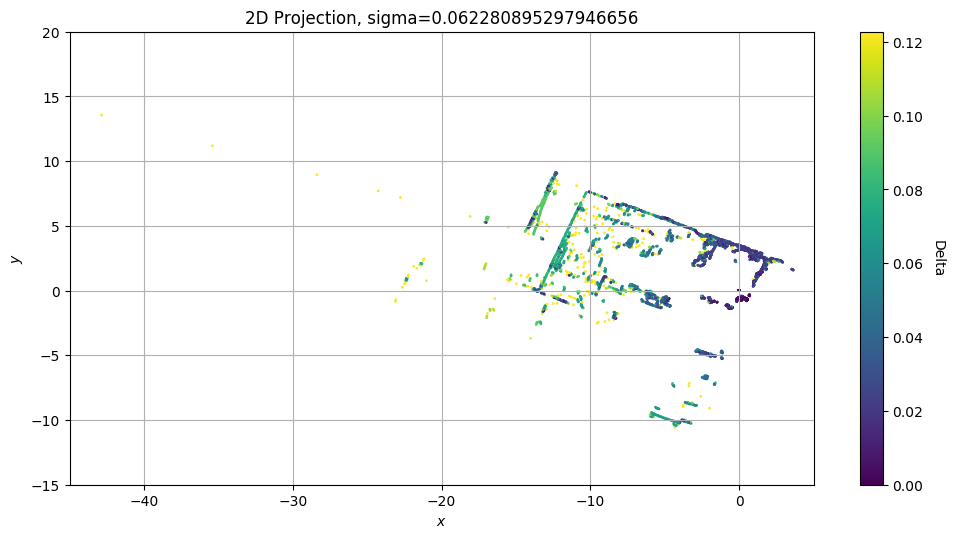

In [18]:
%matplotlib inline

max_delta=20*2*math.pi/1024
xy_delta=np.where(xy_delta<=max_delta,xy_delta,max_delta)

fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(xy_proj[:,0], xy_proj[:,1],s=1,c=xy_delta, alpha=1,cmap='viridis')
plt.grid()
cbar=plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Delta', rotation=270)
# cbar.set_clim(0, max_delta)

plt.xlim(-45,  5)
plt.ylim(-15, 20)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("2D Projection, sigma="+str(sigma))
plt.show((24,10))

In [21]:
%matplotlib inline

max_zdelta=20*2*math.pi*33.2/360/16
print(max_zdelta,max(z_delta))
z_delta=np.where(z_delta<=max_zdelta,z_delta,max_zdelta)


fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(xy_proj[:,0], xy_proj[:,1],s=1,c=z_delta, alpha=1,cmap='viridis')
plt.grid()
cbar=plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Z Delta', rotation=270)
cbar.set_clim(0, min(max_zdelta,max(z_delta)))

plt.xlim(-45,  5)
plt.ylim(-15, 20)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("2D Projection, sigma="+str(sigma))
plt.show((24,10))

0.7243116395776468 0.7243116395776468


In [22]:
max_zdelta

0.7243116395776468

In [25]:
xyz_static=[]

for f in range(100):
    dir_list=os.listdir(inputpath)
    lidar_df=pd.read_csv(os.path.join(inputpath,framefile%"{:04d}".format(f)),header=0)
    xyz_np=lidar_df[["Point:0","Point:1","Point:2"]].values
    xyz_static.append(xyz_np)
xyz_ave=np.mean(xyz_static,axis=0)
xyz_std=np.std(xyz_static,axis=1)

In [26]:
xyz_static.shape

(16384, 3)